# Neural Computing Coursework: MLP vs. SVM
## Ayliah Fani
-------------------------------

In [298]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#sns.set_palette("hls")
sns.set_context("notebook")

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import wordnet

import string

import torch
import torch.nn as nn
import torch.functional as F

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

## 1. Data Import

In [299]:
# import the data
df_test = pd.read_csv('Data/Emotions/test.txt', sep=',', delimiter=';', header=None, names=['sentence','emotion'])
df_train = pd.read_csv('Data/Emotions/train.txt', sep=',', delimiter=';', header=None, names=['sentence','emotion'])
df_val = pd.read_csv('Data/Emotions/val.txt', sep=',', delimiter=';', header=None, names=['sentence','emotion'])

df = pd.concat([df_test, df_train, df_val])
df = df.reset_index(drop=True)

## 2. Exploratory Data Analysis
### Number of emotions represented

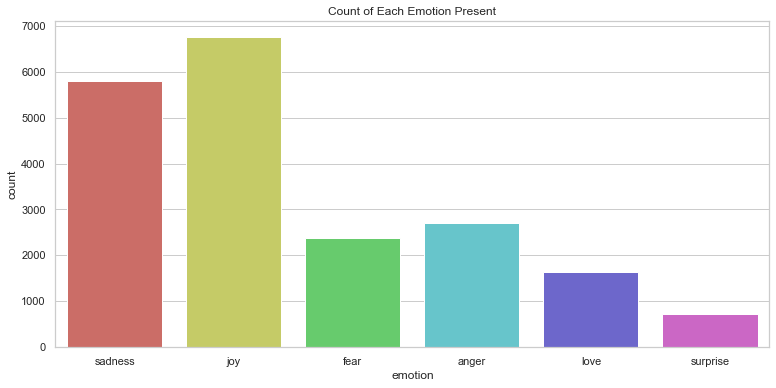

In [300]:
# find the count of each emotion represented.
plt.figure(figsize=(12.8,6))
sns.countplot(x='emotion', data=df).set_title('Count of Each Emotion Present');

From the count plot we can see that this is an imbalanced classification problem.

### Sentence Length

/Users/Ayliah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


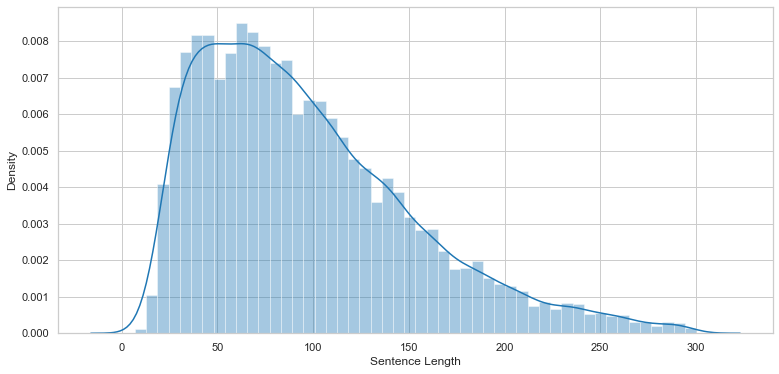

In [301]:
sentence_length = df['sentence'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(sentence_length, kde=True, color='#1f77b4')
plt.xlabel('Sentence Length');

In [302]:
sentence_length.describe()

count    20000.000000
mean        96.670050
std         55.777923
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: sentence, dtype: float64

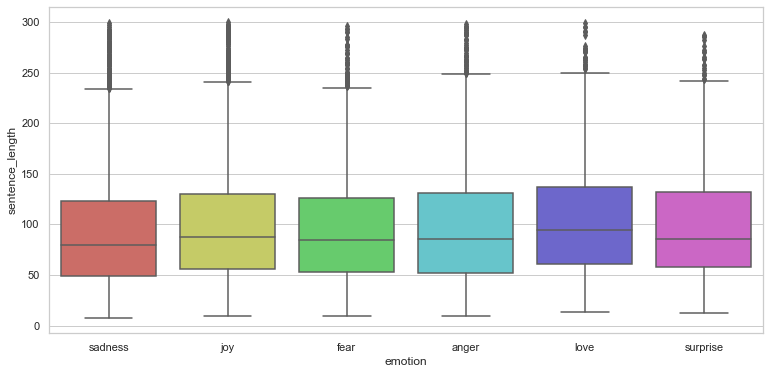

In [303]:
df['sentence_length'] = sentence_length

plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='emotion', y='sentence_length');

sentences of each emotion are generally the same length

## 3. Feature Engineering

### 3.1 Text Prep & Cleaning

In [304]:
stop_words = stopwords.words('english')
stop_words.extend(['im','ive','https','href'])

In [305]:
# method from: https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e


# pos
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.VERB
    

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stop_words]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # there are still some errors after lemmatising 'feeling' so do it again
    text = [WordNetLemmatizer().lemmatize(t, pos='v') for t in text]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["sentence"] = df["sentence"].apply(lambda x: clean_text(x))

### 3.2 Encoding

In [306]:
emotion_dict = {'sadness':0, 'joy':1, 'fear':2, 'anger':3, 'love':4, 'surprise':5}

df['emotion'] = df['emotion'].map(emotion_dict)

### 3.3 Train-Test Split

In [307]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], 
                                                    df['emotion'], 
                                                    test_size=0.2, 
                                                    random_state=0)

### 3.4 Text Representation

In [308]:
# parameters
ngram_range = (1,2)
min_df = 10
max_df = 1.0
max_features = 300

In [309]:
tfidf = TfidfVectorizer(ngram_range=ngram_range,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(16000, 300)
(4000, 300)


In [312]:
from sklearn.feature_selection import chi2
import numpy as np

for emotion, emotion_id in sorted(emotion_dict.items()):
    features_chi2 = chi2(features_train, labels_train == emotion_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("-- '{}' category:".format(emotion))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

-- 'anger' category:
  . Most correlated unigrams:
. frustrate
. fuck
. cold
. bother
. angry
  . Most correlated bigrams:
. feel pretty
. feel amaze

-- 'fear' category:
  . Most correlated unigrams:
. weird
. strange
. pressure
. afraid
. anxious
  . Most correlated bigrams:
. feel bite
. feel little

-- 'joy' category:
  . Most correlated unigrams:
. wonderful
. glad
. cool
. proud
. content
  . Most correlated bigrams:
. feel pretty
. feel bite

-- 'love' category:
  . Most correlated unigrams:
. long
. passionate
. care
. love
. sweet
  . Most correlated bigrams:
. get feel
. feel like

-- 'sadness' category:
  . Most correlated unigrams:
. bad
. stupid
. sorry
. guilty
. depress
  . Most correlated bigrams:
. feel bite
. feel amaze

-- 'surprise' category:
  . Most correlated unigrams:
. remember
. weird
. strange
. overwhelm
. amaze
  . Most correlated bigrams:
. feel little
. feel amaze

